# **Buynomics - Price Optimization Task**

### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

### **Initial Data Exploration: Sales Data**

In [2]:
# file path based on  directory structure
file_path_sales = '../data_files/sales.csv'
file_path_products = '../data_files/product.csv'

In [3]:
# reading sales data
sales = pd.read_csv(file_path_sales, index_col =0)
sales.sample(7, random_state = 42)

,date,product_id,price,units
30,2020-01-01,3,2.70,1478.0
186,2020-01-07,18,3.88,1559.0
232,2020-01-03,23,4.65,1144.0
190,2020-01-01,19,9.10,345.0
220,2020-01-01,22,6.15,826.0
268,2020-01-09,26,3.38,1603.0
178,2020-01-09,17,4.17,1057.0


In [4]:
# dimesions of data
sales.shape

(260, 4)

In [5]:
# sum of NA values in each columns
sales.isna().sum()

date          0
product_id    0
price         0
units         0
dtype: int64

In [6]:
# the number of duplicate values in each column
duplicate_counts = sales.apply(lambda col: col.duplicated().sum())

print(duplicate_counts)

date          250
product_id    233
price          42
units          26
dtype: int64


In [7]:
# info about null values and data types
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260 entries, 0 to 269
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        260 non-null    object 
 1   product_id  260 non-null    int64  
 2   price       260 non-null    float64
 3   units       260 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 10.2+ KB


<span style="color:red;font-size:14px">[Note] Date column needs to be converted to timestamp </span>

In [8]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
product_id,260.0,12.911538,7.846738,0.00,6.000,13.00,20.000,26.00
price,260.0,5.288538,1.881547,1.46,3.965,5.14,6.785,9.42
units,260.0,1177.496154,401.771103,16.00,944.000,1275.50,1453.250,2170.00


### **Initial Data Exploration: Product Data**

In [9]:
# reading product data
product = pd.read_csv(file_path_products, index_col = 0)
product.sample(7, random_state = 42)

,brand,flavour,volume_per_joghurt_g,packsize,product_id
8,Alnatura,straciatella,150,6,8
13,Danone,chocolate,150,6,13
9,Activia,blueberry,1000,6,9
21,Danone,strawberry,1000,6,21
0,Mueller,blueberry,150,6,0
11,Ja!,blueberry,500,6,11
16,Ja!,straciatella,500,6,16


In [10]:
# dimensions of data
product.shape

(27, 5)

In [11]:
# sum of NA values in each column
product.isna().sum()

brand                   0
flavour                 0
volume_per_joghurt_g    0
packsize                0
product_id              0
dtype: int64

In [12]:
# the number of duplicate values in each column
duplicate_counts1 = product.apply(lambda col: col.duplicated().sum())

print(duplicate_counts1)

brand                   18
flavour                 22
volume_per_joghurt_g    24
packsize                25
product_id               0
dtype: int64


In [13]:
# info about data types and non-null count
product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   brand                 27 non-null     object
 1   flavour               27 non-null     object
 2   volume_per_joghurt_g  27 non-null     int64 
 3   packsize              27 non-null     int64 
 4   product_id            27 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 1.3+ KB


In [14]:
# Num of unique values in each column
product.nunique()

brand                    9
flavour                  5
volume_per_joghurt_g     3
packsize                 2
product_id              27
dtype: int64

### **Data Pre-Processing**

#### *In this section I will convert "date" column in sales data into date format to extract year, month, and day. Because extracting year, month, and day from sales data is crucial for business analysis, forecasting, and trend identification.*

In [15]:
# Converting date column of sales data into a timestamp
sales['date'] = pd.to_datetime(sales['date'])

# Check the data types
print(sales.dtypes)

date          datetime64[ns]
product_id             int64
price                float64
units                float64
dtype: object


In [16]:
# Extracting year, short month name, short day name, and numeric day of month from "date" column
sales["year"] = sales["date"].dt.year

# Short names for day of week and month like Wed, Thu or Jan are better for visualisation 
sales["month"] = sales["date"].dt.strftime("%b")  
sales["day_of_week"] = sales["date"].dt.strftime("%a")   
sales["day"] = sales["date"].dt.day  

In [17]:
# Creating revenue column
sales["revenue"] = sales["price"] * sales["units"]

In [18]:
sales.head()

,date,product_id,price,units,year,month,day_of_week,day,revenue
0,2020-01-01,0,4.65,1126.0,2020,Jan,Wed,1,5235.90
1,2020-01-02,0,4.76,1205.0,2020,Jan,Thu,2,5735.80
2,2020-01-03,0,5.22,1007.0,2020,Jan,Fri,3,5256.54
3,2020-01-04,0,5.45,1282.0,2020,Jan,Sat,4,6986.90
4,2020-01-05,0,3.33,1037.0,2020,Jan,Sun,5,3453.21


In [19]:
# Convert packsize to a categorical variable
product["packsize_category"] = product["packsize"].map({1: "Single", 6: "Multipack"})

# Check unique values
print(product["packsize_category"].unique())

['Multipack' 'Single']


#### **Merging Sales and Product Data**

In [20]:
# Inner joining on product_id
merged_data = pd.merge(sales, product, how = "inner", on = "product_id")
merged_data.head()

,date,product_id,price,units,year,month,day_of_week,day,revenue,brand,flavour,volume_per_joghurt_g,packsize,packsize_category
0,2020-01-01,0,4.65,1126.0,2020,Jan,Wed,1,5235.90,Mueller,blueberry,150,6,Multipack
1,2020-01-02,0,4.76,1205.0,2020,Jan,Thu,2,5735.80,Mueller,blueberry,150,6,Multipack
2,2020-01-03,0,5.22,1007.0,2020,Jan,Fri,3,5256.54,Mueller,blueberry,150,6,Multipack
3,2020-01-04,0,5.45,1282.0,2020,Jan,Sat,4,6986.90,Mueller,blueberry,150,6,Multipack
4,2020-01-05,0,3.33,1037.0,2020,Jan,Sun,5,3453.21,Mueller,blueberry,150,6,Multipack


<span style = "color:red" > [Note] Because all the products(id) from the product data appear in the sales data - to do left or inner join will not make any difference in this case. However, if this would not be the case, and we would still like to keep the products that are not in the sales data, left join is the right way. </span> 

In [21]:
# Re-ordering columns

# desired column order
column_order = [
    "product_id", "brand", "flavour", "volume_per_joghurt_g", "packsize","packsize_category",
    "price", "units","revenue", "date", "year", "month", "day", "day_of_week"
]

# Reorder 
merged_data = merged_data[column_order]
merged_data.head()

,product_id,brand,flavour,volume_per_joghurt_g,packsize,packsize_category,price,units,revenue,date,year,month,day,day_of_week
0,0,Mueller,blueberry,150,6,Multipack,4.65,1126.0,5235.90,2020-01-01,2020,Jan,1,Wed
1,0,Mueller,blueberry,150,6,Multipack,4.76,1205.0,5735.80,2020-01-02,2020,Jan,2,Thu
2,0,Mueller,blueberry,150,6,Multipack,5.22,1007.0,5256.54,2020-01-03,2020,Jan,3,Fri
3,0,Mueller,blueberry,150,6,Multipack,5.45,1282.0,6986.90,2020-01-04,2020,Jan,4,Sat
4,0,Mueller,blueberry,150,6,Multipack,3.33,1037.0,3453.21,2020-01-05,2020,Jan,5,Sun


### **EDA for Mueller**

In [22]:
mueller_df = merged_data[merged_data["brand"] == "Mueller"].copy()
mueller_df.head()

,product_id,brand,flavour,volume_per_joghurt_g,packsize,packsize_category,price,units,revenue,date,year,month,day,day_of_week
0,0,Mueller,blueberry,150,6,Multipack,4.65,1126.0,5235.90,2020-01-01,2020,Jan,1,Wed
1,0,Mueller,blueberry,150,6,Multipack,4.76,1205.0,5735.80,2020-01-02,2020,Jan,2,Thu
2,0,Mueller,blueberry,150,6,Multipack,5.22,1007.0,5256.54,2020-01-03,2020,Jan,3,Fri
3,0,Mueller,blueberry,150,6,Multipack,5.45,1282.0,6986.90,2020-01-04,2020,Jan,4,Sat
4,0,Mueller,blueberry,150,6,Multipack,3.33,1037.0,3453.21,2020-01-05,2020,Jan,5,Sun


In [23]:
# Selecting relevant columns and drop duplicates to get unique combinations
unique_products = mueller_df[["product_id", "flavour", "volume_per_joghurt_g", "packsize", "year"]].drop_duplicates()

# Printing in a clear tabular format
print(unique_products.to_string(index=False))

 product_id      flavour  volume_per_joghurt_g  packsize  year
          0    blueberry                   150         6  2020
          3 straciatella                   500         6  2020
         10    chocolate                  1000         6  2020
         17   strawberry                   150         6  2020


[Note] We can see that flavours blueberry(id=0), strawberry(id=17) have 150g jogurts, while flavours straciatella (id=3) and chocolate(id=10) have 500g and 1000g jogurts, respectively. The packsizes and volumes are not changed during the timeframe.

In [24]:
# To see single and multi-pack products 
mueller_df['packsize_category'].value_counts()

packsize_category
Multipack    40
Name: count, dtype: int64

<span style ="color:red">[Note] The result shows that Mueller only sells multi-pack products </span>

## **Product Segmentation & Flavour-Based Analysis**

### Since we are dealing with multiple yogurt flavours (different products), it’s best to segment products by flavour and analyze:
1. Total revenue and price changes for each flavour
2. How price for each flavour changes over time
3. How revenue changes over time

In [25]:
# Group by flavour and calculate total revenue & average price
flavour_analysis = mueller_df.groupby("flavour").agg(
    total_revenue=("revenue", "sum"),
    avg_price=("price", "mean"),
    total_units_sold = ("units", "sum")
).reset_index()

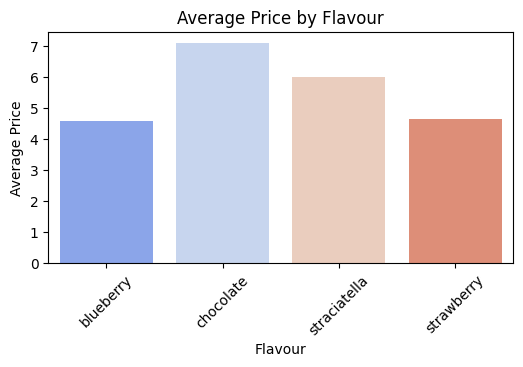

In [26]:
# Plot average price per flavour
plt.figure(figsize=(6,3))
sns.barplot(data=flavour_analysis, x="flavour", y="avg_price", palette="coolwarm")
plt.xlabel("Flavour")
plt.ylabel("Average Price")
plt.title("Average Price by Flavour")
plt.xticks(rotation=45)
plt.show()

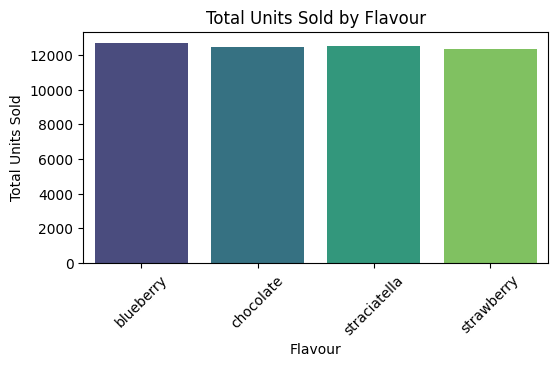

In [27]:
# Plot total units sold per flavour
plt.figure(figsize=(6,3))
sns.barplot(data=flavour_analysis, x="flavour", y="total_units_sold", palette="viridis")
plt.xlabel("Flavour")
plt.ylabel("Total Units Sold")
plt.title("Total Units Sold by Flavour")
plt.xticks(rotation=45)
plt.show()

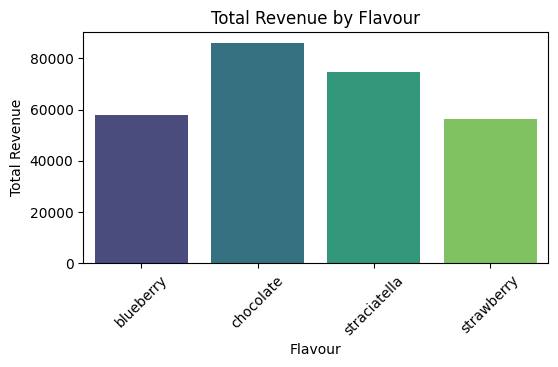

In [28]:
# Plot revenue per flavour
plt.figure(figsize=(6,3))
sns.barplot(data=flavour_analysis, x="flavour", y="total_revenue", palette="viridis")
plt.xlabel("Flavour")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Flavour")
plt.xticks(rotation=45)
plt.show()

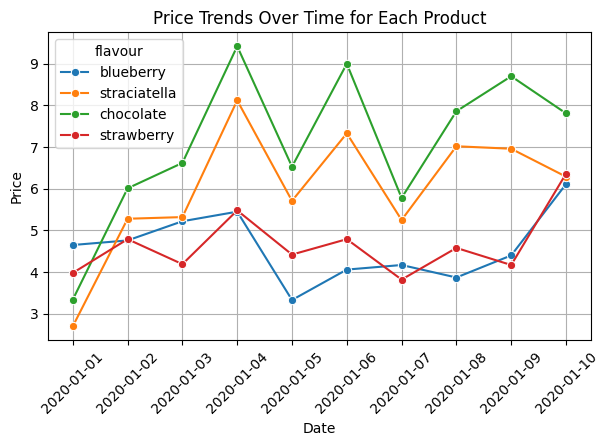

In [29]:
# Plot price trends for each flavor
plt.figure(figsize=(7,4))
sns.lineplot(data=mueller_df, x="date", y="price", hue="flavour", marker="o")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price Trends Over Time for Each Product")
plt.xticks(rotation=45)
plt.grid()
plt.show()

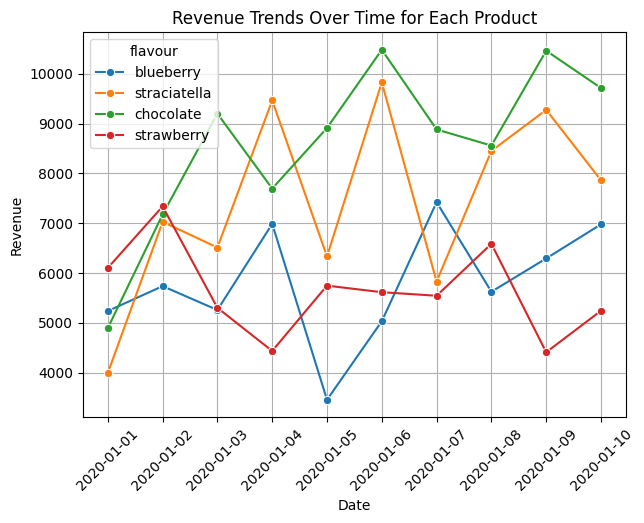

In [30]:
# Plot revenue trends for each flavor
plt.figure(figsize=(7,5))
sns.lineplot(data=mueller_df, x="date", y="revenue", hue="flavour", marker="o")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue Trends Over Time for Each Product")
plt.xticks(rotation=45)
plt.grid()
plt.show()

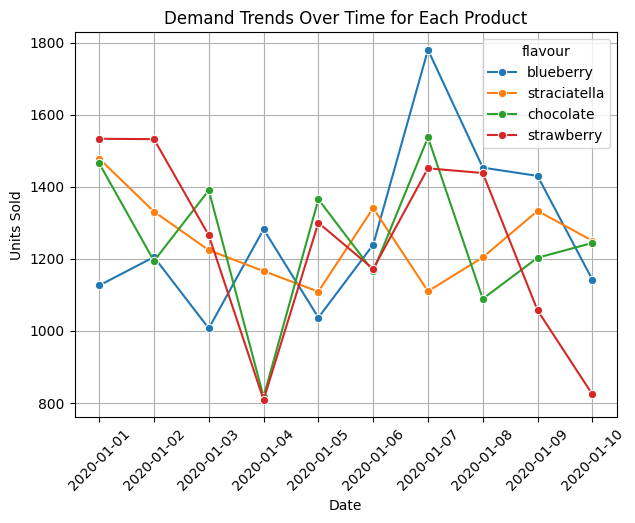

In [31]:
# Plot revenue trends for each flavor
plt.figure(figsize=(7,5))
sns.lineplot(data=mueller_df, x="date", y="units", hue="flavour", marker="o")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("Demand Trends Over Time for Each Product")
plt.xticks(rotation=45)
plt.grid()
plt.show()

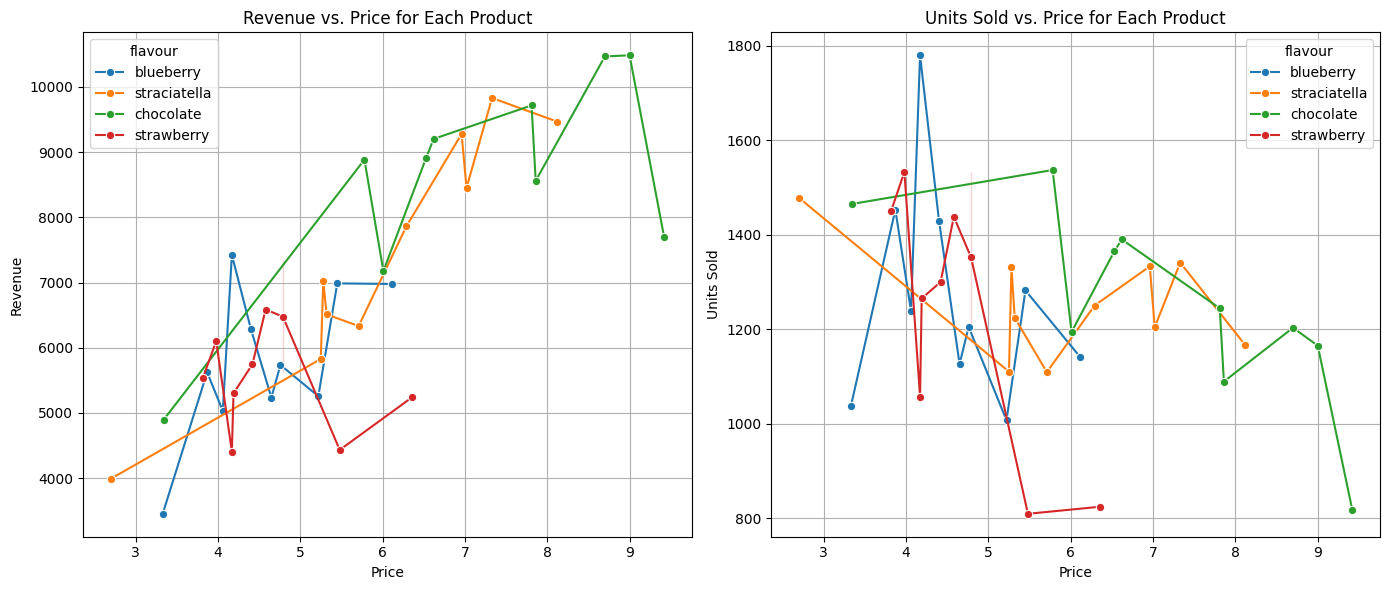

In [32]:
# Creating a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Price vs. Revenue

sns.lineplot(data=mueller_df, x="price", y="revenue", hue="flavour", marker="o", linestyle="-", ax=axes[0])
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Revenue")
axes[0].set_title("Revenue vs. Price for Each Product")
axes[0].grid()

# Price vs. Units Sold  
sns.lineplot(data=mueller_df, x="price", y="units", hue="flavour", marker="o", linestyle="-", ax=axes[1])
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Units Sold")
axes[1].set_title("Units Sold vs. Price for Each Product")
axes[1].grid()

plt.tight_layout()
plt.show()

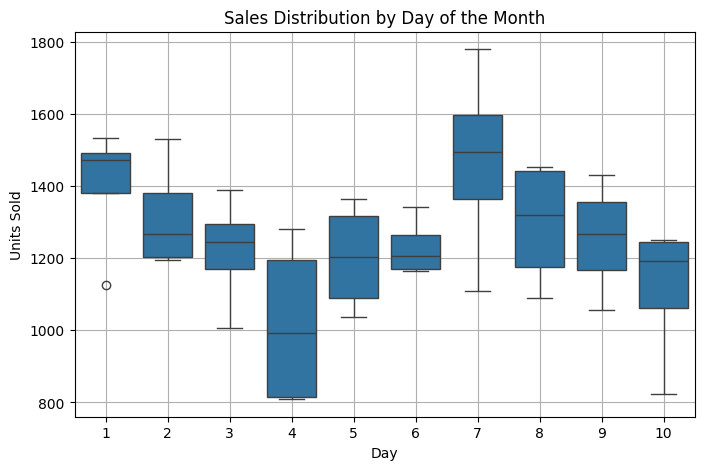

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(data=mueller_df, x="day", y="units")
plt.xlabel("Day")
plt.ylabel("Units Sold")
plt.title("Sales Distribution by Day of the Month")
plt.grid()
plt.show()

# **Developing a Model to Predict Units Sold Based on Price (Elasticity Model)**

## We need to predict units sold from price using elasticity and product attributes. This involves:
1. Understanding Price Elasticity (How demand changes with price)
2. Building a Regression Model (Units ~ Price + Product Attributes)
3. Fitting the Model to Data
4. Evaluating Risk Against a Baseline Model

### Preparing Data for Modeling

In [34]:
# Ensure no zero values before applying log (avoid log(0) issue)
mueller_df = mueller_df[mueller_df["price"] > 0]
mueller_df = mueller_df[mueller_df["units"] > 0]

In [35]:
# Log transformation
mueller_df["log_units"] = np.log(mueller_df["units"])
mueller_df["log_price"] = np.log(mueller_df["price"])

In [36]:
mueller_df.columns

Index(['product_id', 'brand', 'flavour', 'volume_per_joghurt_g', 'packsize',
       'packsize_category', 'price', 'units', 'revenue', 'date', 'year',
       'month', 'day', 'day_of_week', 'log_units', 'log_price'],
      dtype='object')

### Train a Regression Model

#### Encode Categorical Variables (packsize_category, flavour, day_of_week)

In [37]:
# Converting categorical variables into dummy variables
mueller_df = pd.get_dummies(mueller_df, columns=["flavour", "day_of_week"], drop_first=True)

<span style = "color:red" > [Note] In this dataset, Monday, Tuesday, and Wednesday each appear twice, while other days appear only once. This imbalance can introduce noise when using “day_of_week” as a categorical variable since the limited time span (only 10 days) does not provide a full picture of weekly sales patterns. As a result, any observed effects may not generalize well, making it a potential drawback in the analysis. </span>

In [38]:
mueller_df.columns

Index(['product_id', 'brand', 'volume_per_joghurt_g', 'packsize',
       'packsize_category', 'price', 'units', 'revenue', 'date', 'year',
       'month', 'day', 'log_units', 'log_price', 'flavour_chocolate',
       'flavour_straciatella', 'flavour_strawberry', 'day_of_week_Mon',
       'day_of_week_Sat', 'day_of_week_Sun', 'day_of_week_Thu',
       'day_of_week_Tue', 'day_of_week_Wed'],
      dtype='object')

#### Defining Features and Label

In [39]:
# Define independent variables
X = mueller_df[["log_price", "volume_per_joghurt_g"] + 
               [col for col in mueller_df.columns if col.startswith("flavour_")] + 
               [col for col in mueller_df.columns if col.startswith("day_of_week_")]]

# Add intercept term
X = sm.add_constant(X)

In [40]:
X = X.astype(int)  # Convert all bool columns to int (0/1)
print(X.dtypes)  # Check results

const                   int64
log_price               int64
volume_per_joghurt_g    int64
flavour_chocolate       int64
flavour_straciatella    int64
flavour_strawberry      int64
day_of_week_Mon         int64
day_of_week_Sat         int64
day_of_week_Sun         int64
day_of_week_Thu         int64
day_of_week_Tue         int64
day_of_week_Wed         int64
dtype: object


In [41]:
X.head()

,const,log_price,volume_per_joghurt_g,flavour_chocolate,flavour_straciatella,flavour_strawberry,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed
0,1,1,150,0,0,0,0,0,0,0,0,1
1,1,1,150,0,0,0,0,0,0,1,0,0
2,1,1,150,0,0,0,0,0,0,0,0,0
3,1,1,150,0,0,0,0,1,0,0,0,0
4,1,1,150,0,0,0,0,0,1,0,0,0


In [42]:
# Define dependent variable (log of units sold)
y = mueller_df["log_units"]

In [43]:
y.head()

0    7.026427
1    7.094235
2    6.914731
3    7.156177
4    6.944087
Name: log_units, dtype: float64

#### Fit the Model

In [44]:
# Fit an OLS regression model
model = sm.OLS(y, X).fit()

# Display model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     1.721
Date:                Tue, 18 Mar 2025   Prob (F-statistic):              0.123
Time:                        14:39:37   Log-Likelihood:                 23.439
No. Observations:                  40   AIC:                            -24.88
Df Residuals:                      29   BIC:                            -6.300
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.9763 

In [45]:
# Compute Residual Sum of Squares (RSS)
RSS = np.sum(model.resid ** 2)

# Compute Total Sum of Squares (TSS)
TSS = np.sum((y - y.mean()) ** 2)

# Compute Explained Sum of Squares (ESS)
ESS = TSS - RSS

# Compute RMSE (Root Mean Squared Error)
RMSE = np.sqrt(RSS / len(y))

# Compute MAE (Mean Absolute Error)
MAE = np.mean(np.abs(model.resid))

# Display Additional Metrics
print(f"Residual Sum of Squares (RSS): {RSS:.4f}")
print(f"Total Sum of Squares (TSS): {TSS:.4f}")
print(f"Explained Sum of Squares (ESS): {ESS:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
print(f"Mean Absolute Error (MAE): {MAE:.4f}")

Residual Sum of Squares (RSS): 0.7255
Total Sum of Squares (TSS): 1.1561
Explained Sum of Squares (ESS): 0.4306
Root Mean Squared Error (RMSE): 0.1347
Mean Absolute Error (MAE): 0.1112


**Model Evaluation Summary**

- The regression model explains 37.2% of the variation in sales (log_units). The Residual Sum of Squares (RSS) of 0.7255 indicates some remaining error, while the Explained Sum of Squares (ESS) of 0.4306 shows the portion of variability captured by the model.

- The Root Mean Squared Error (RMSE) of 0.1347 and Mean Absolute Error (MAE) of 0.1112 suggest that the model’s predictions are reasonably accurate, with small deviations from actual values. The small difference between RMSE and MAE indicates no large outliers significantly affecting predictions.

- While the model performs well, improvements can be made by incorporating competitor prices, seasonal trends, or interaction effects.

#### Checking for multicollinearity using the Variance Inflation Factor (VIF)
- Drop variables with very high VIF (>5) to reduce multicollinearity.

In [46]:
# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                Variable       VIF
0                  const  0.000000
1              log_price  1.758621
2   volume_per_joghurt_g       inf
3      flavour_chocolate       inf
4   flavour_straciatella       inf
5     flavour_strawberry  1.500000
6        day_of_week_Mon  1.365517
7        day_of_week_Sat  1.489655
8        day_of_week_Sun  1.365517
9        day_of_week_Thu  1.600000
10       day_of_week_Tue  1.365517
11       day_of_week_Wed  1.627586


## Visualizations based on the model

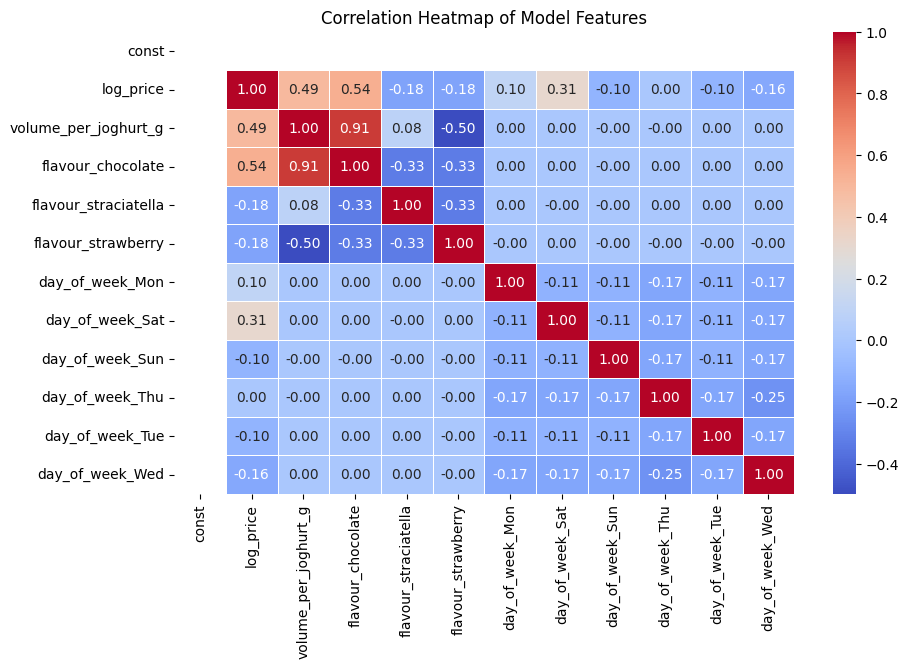

In [47]:
# Compute the correlation matrix for independent variables
correlation_matrix = X.corr()

# Create a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap of Model Features")

# Show the plot
plt.show()

[Note]The heatmap shows strong correlations between volume_per_joghurt_g and flavour_chocolate (0.91), suggesting multicollinearity. Log_price has moderate correlations with some flavour variables, indicating price differences across flavours. Day_of_week variables show weak correlations.

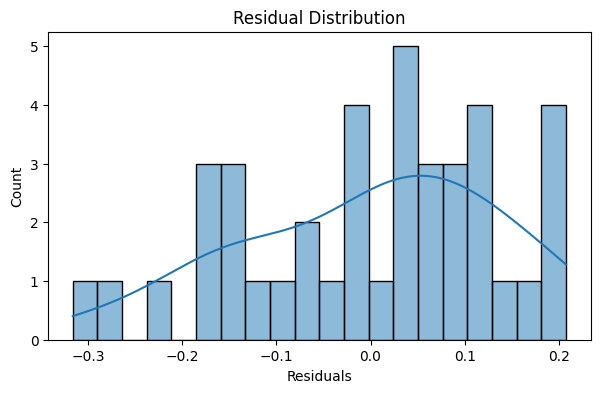

In [48]:
residuals = model.resid
plt.figure(figsize=(7,4))
sns.histplot(residuals, bins=20, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

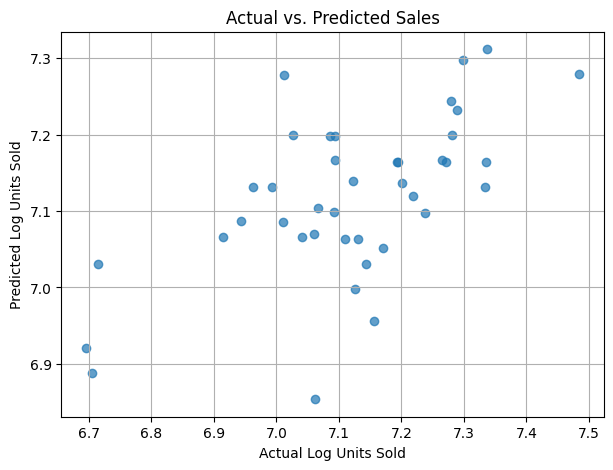

In [49]:
plt.figure(figsize=(7,5))
plt.scatter(y, model.fittedvalues, alpha=0.7)
plt.xlabel("Actual Log Units Sold")
plt.ylabel("Predicted Log Units Sold")
plt.title("Actual vs. Predicted Sales")
plt.grid()
plt.show()

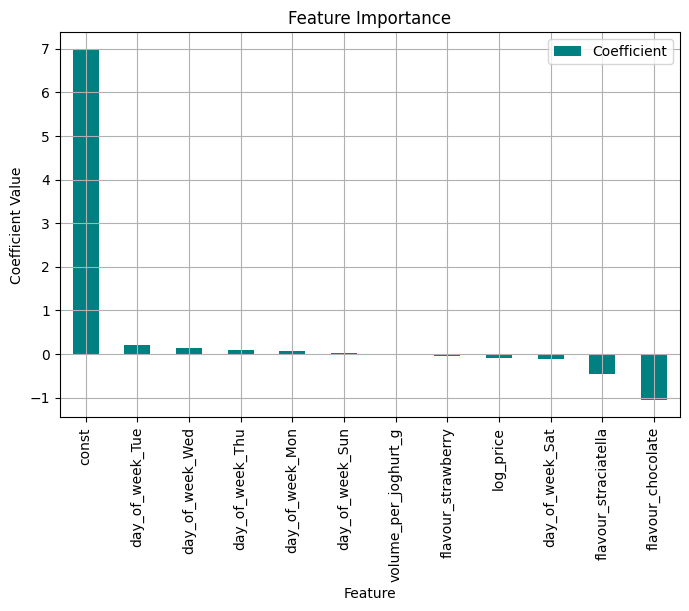

In [50]:
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": model.params}).set_index("Feature")
coef_df.sort_values(by="Coefficient", ascending=False).plot(kind="bar", figsize=(8,5), color="teal")
plt.title("Feature Importance")
plt.ylabel("Coefficient Value")
plt.grid()
plt.show()

## **Summary of the Linear Demand Model**

This regression model analyzes the relationship between price, product attributes, and sales in the yogurt market. While the model explains some variation in sales, the results suggest that price alone is not the strongest driver of sales, as other factors like product volume, flavor preferences, and day of the week also play significant roles.

- **Key Takeaways:**
    - Price elasticity is weak, indicating that sales are not highly sensitive to price changes in this dataset. This suggests that other product attributes and external factors may have a greater impact on demand.
    - Larger yogurt volumes tend to sell more, making product size an important factor for revenue optimization.
    - Flavor significantly affects sales, with some flavors performing better than others, suggesting potential for differentiated pricing or targeted promotions.
    - Day of the week has some influence on sales, with certain weekdays showing higher demand, which could be leveraged for strategic pricing adjustments.

- How to Use This for Price Optimization:
    - Instead of applying a uniform price elasticity, testing segment-specific pricing strategies (based on flavor, pack size, or weekday trends) may yield better results.
    -  Promotional strategies for underperforming flavors and bundling larger packs could enhance revenue.
    -	Further modeling improvements, such as incorporating external factors (e.g., seasonality, competitor pricing), could refine pricing strategies for better sales predictions.

- **Next Steps:**
    -   Improve the model by testing interaction effects (e.g., price × volume).
    -   Analyze demand trends per segment to optimize pricing for different product types.
    -   Test different pricing simulations to estimate the most profitable price points.
    -   Monitor competitor pricing trends: Comparing our prices to competitors (e.g., Oikos, Alnatura) can help determine if price adjustments are needed to stay competitive.
    -   Cross-price elasticity analysis: Understanding how our sales respond to changes in competitor prices can guide optimal discounting strategies.
    -   Market positioning: If competitors dominate a certain segment (e.g., premium pricing for specific flavors), we could differentiate our pricing strategy by targeting gaps in the market.
    -   Seasonality effects: Analyzing when competitors run promotions can help us adjust our own pricing strategies to maximize market share.

This model provides a foundational understanding of how pricing and product attributes influence sales, but further refinements are needed for precise price optimization strategies.

# **Using the Model for Prediction**

In [51]:
# Generate test prices (from min to max)
test_prices = np.linspace(mueller_df["price"].min(), mueller_df["price"].max(), 10)

# Create test data for predictions
test_data = pd.DataFrame({"log_price": np.log(test_prices), "volume_per_joghurt_g": 500})  # Assuming 500g size

# Add missing categorical variables as 0
for col in X.columns:
    if col not in test_data.columns:
        test_data[col] = 0

# Add constant
test_data = sm.add_constant(test_data)

# Predict sales
test_data["predicted_units"] = np.exp(model.predict(test_data))

print(test_data[["log_price", "predicted_units"]])

   log_price  predicted_units
0   0.993252     1.420667e-19
1   1.237408     7.802361e-19
2   1.433496     3.064269e-18
3   1.597365     9.611958e-18
4   1.738124     2.566124e-17
5   1.861493     6.068130e-17
6   1.971299     1.305397e-16
7   2.070233     2.603074e-16
8   2.160253     4.877837e-16
9   2.242835     8.678221e-16
